In [159]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import tqdm as notebook_tqdm

sns.set_style("darkgrid")
np.random.seed(42)

## データ生成

### スペクトル生成

In [160]:
K = 3
N = 100
D = 50

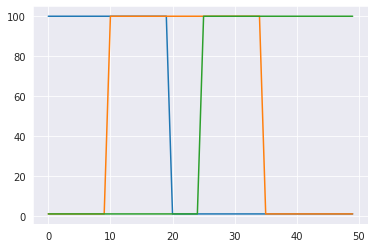

In [161]:
W_t = np.ones([D, K])
W_t[:20, 0] = 100
W_t[10:35, 1] = 100
W_t[25:, 2] = 100

plt.plot(W_t[:, 0])
plt.plot(W_t[:, 1])
plt.plot(W_t[:, 2])

W_t = jnp.array(W_t)

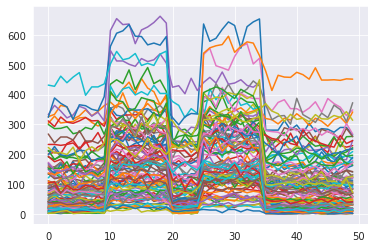

In [162]:
H_t = np.random.gamma(shape=1, scale=1, size=(K, N))
X = np.random.poisson(W_t@H_t)

for n in range(N):
    plt.plot(X[:, n])
plt.show()

### ターゲット変数の生成

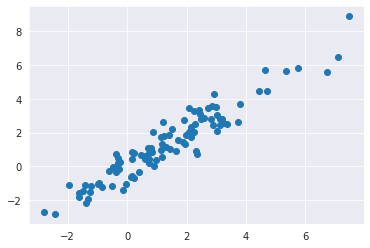

In [163]:
w_t = jnp.array([1.0, 1.5, -1.0])
f_t = w_t@H_t
y = f_t + np.random.normal(loc=0, scale=0.7, size=N)

plt.scatter(f_t, y)

## 解析モデル

In [164]:
def model(K, X, y):
    
    ## スペクトル生成
    ## --------------------------------------------------------------------------------
    # D×Kの行列W
    W = numpyro.sample("W", dist.Gamma(concentration=1, rate=0.01).expand([D, K]))
    # K×Nの行列H
    H = numpyro.sample("H", dist.Gamma(concentration=1, rate=1).expand([K, N]))
    
    with numpyro.plate("energy", X.shape[0], dim=-2):
        with numpyro.plate("sample", X.shape[1], dim=-1):
            numpyro.sample("X", dist.Poisson(W@H), obs=X)
 
    ## ターゲット予測
    # --------------------------------------------------------------------------------
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfNormal(1.0))  # observation noise
    
    # w = numpyro.sample("w", numpyro.distributions.Normal(0, 10).expand([H.shape[0]])) 
    beta = numpyro.deterministic("beta", jnp.linalg.lstsq(H.T, y, rcond=None)[0])
    
    # f = numpyro.deterministic("f", w@H)
    
    with numpyro.plate("sample", X.shape[1]):
        numpyro.sample("y", numpyro.distributions.Normal(beta@H, sigma), obs=y)  # observation model
    

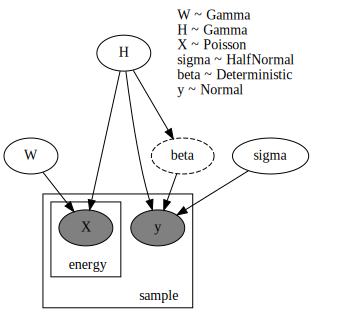

In [139]:
numpyro.render_model(
    model=model, 
    model_kwargs={"K": K, "X": X, "y": y},
    render_params=True, 
    render_distributions=True,
    # filename='prob_model.jpg',
)

### サンプリング

In [166]:
rng_key = jax.random.PRNGKey(42)
num_samples = 5000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_samples,
                            num_samples=num_samples)
mcmc.run(rng_key=rng_key, K=K, X=X, y=y)

samples = mcmc.get_samples()

sample: 100%|██████████| 10000/10000 [01:13<00:00, 136.19it/s, 63 steps of size 4.50e-02. acc. prob=0.87]


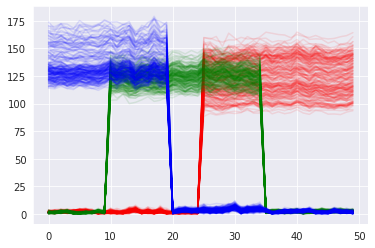

In [167]:
colors = ['red', 'green', 'blue']
for k in range(K):
    c = colors[k]
    for i in range(1, 1000, 5):
        plt.plot( samples['W'][-i, :, k], color=c, alpha=0.1)

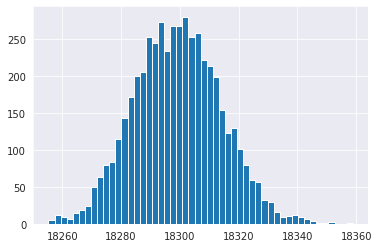

18299.1171875


In [168]:
log_likelihood = numpyro.infer.log_likelihood(model=model, posterior_samples=mcmc.get_samples(), K=K, X=X, y=y)
log_likelihood = -1.0 * ( np.sum(log_likelihood['y'], axis=1) + np.sum(log_likelihood['X'], axis=[1, 2]) )

# plt.hist( log_likelihood - np.min(log_likelihood), bins=40)
plt.hist( log_likelihood, bins=50)
plt.show()

print( float( jnp.mean( log_likelihood ) ) )

In [173]:
index = np.argmin(log_likelihood)
print(log_likelihood[index])

eap_beta = samples['beta'][index, :]
eap_H = samples['H'][index, :]
print(eap_beta.shape)
print(eap_H.shape)

18255.273
(3,)
(3, 100)


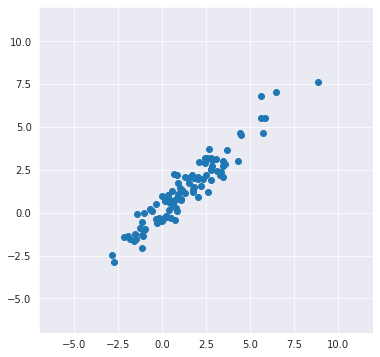

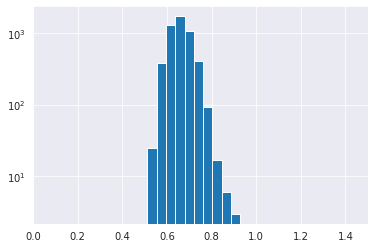

In [177]:
plt.figure(figsize=(6, 6))
y_hat = eap_beta@eap_H
plt.scatter(y, y_hat)
plt.xlim(-7, 12)
plt.ylim(-7, 12)
plt.show()

plt.hist(samples['sigma'])
plt.yscale('log')
plt.xlim(0, 1.5)
plt.show()